In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Quora Dataset/quora.csv')

## Load the Dataset

In [ ]:
df.head()

,Unnamed: 0,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
1,1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
2,2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
3,3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
4,4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


In [ ]:
df.shape

(100000, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    100000 non-null  int64 
 1   index         100000 non-null  int64 
 2   id            100000 non-null  int64 
 3   qid1          100000 non-null  int64 
 4   qid2          100000 non-null  int64 
 5   question1     100000 non-null  object
 6   question2     100000 non-null  object
 7   is_duplicate  100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [ ]:
df['is_duplicate'].value_counts()

0    62879
1    37121
Name: is_duplicate, dtype: int64

Dataset is imbalanced

In [ ]:
len(df.loc[:,['qid1','qid2','is_duplicate']].value_counts())

100000

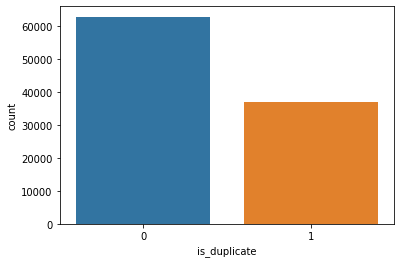

In [ ]:
sns.countplot(x = df['is_duplicate'])

In [ ]:
from wordcloud import WordCloud, STOPWORDS

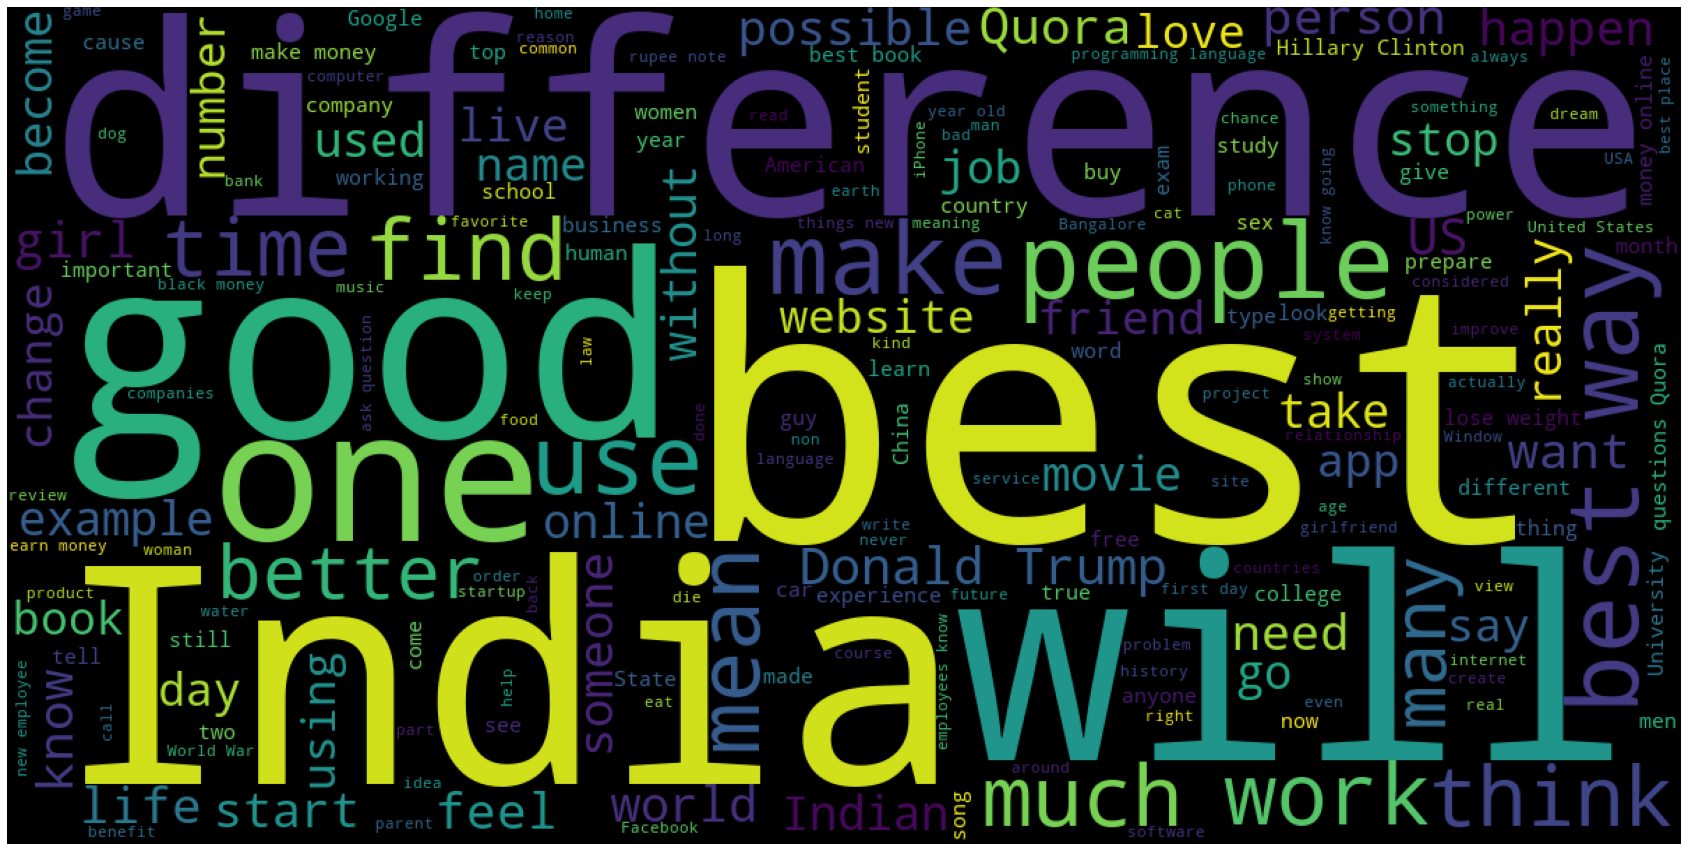

In [ ]:
# WordCloud for Cleaned Question 1
words = ' '.join(df['question1'])
cleaned_word_1 = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(background_color='black',width = 1200, height = 600).generate(cleaned_word_1)
plt.figure(1,figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

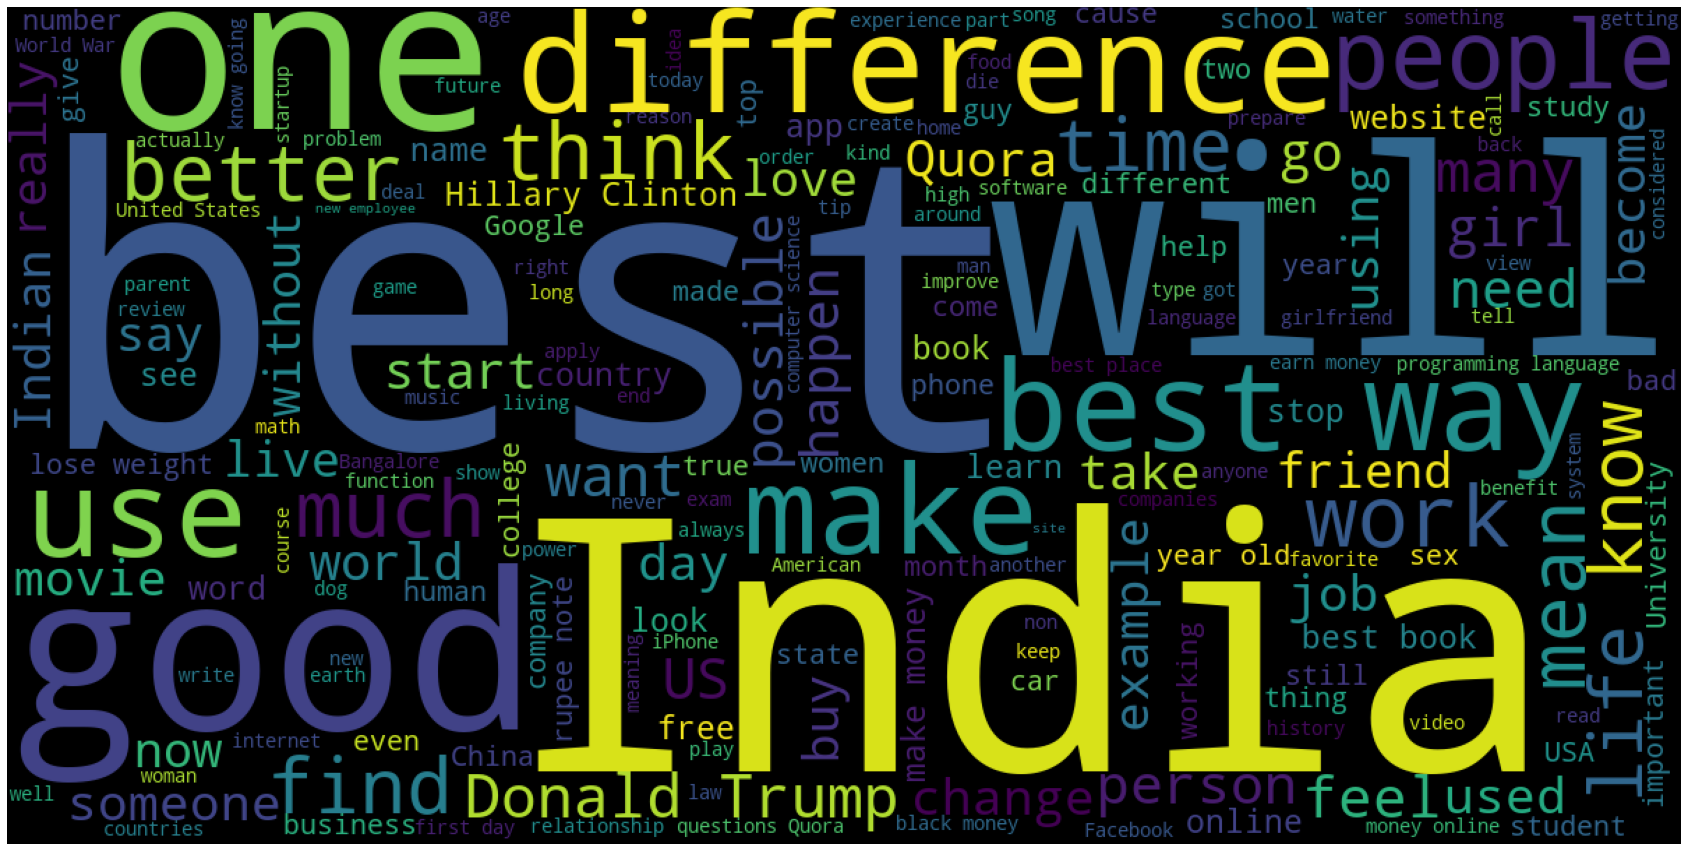

In [ ]:
# WordCloud for Cleaned Question 2
words = ' '.join(df['question2'])
cleaned_word_2 = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(background_color='black',width = 1200, height = 600).generate(cleaned_word_2)
plt.figure(1,figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
df.head()

,Unnamed: 0,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
1,1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
2,2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
3,3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
4,4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


### Data Preprocessing 

In [4]:
df['len_question1'] = df['question1'].apply(lambda x:len(x))
df['len_question2'] = df['question2'].apply(lambda x:len(x))
df['no_of_words_1'] = df['question1'].apply(lambda x:len(x.split()))
df['no_of_words_2'] = df['question2'].apply(lambda x:len(x.split()))

In [5]:
data = df.loc[:,['len_question1', 'len_question2', 'no_of_words_1', 'no_of_words_2']]
target = df['is_duplicate']

In [ ]:
# Data Standardization
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(data)
print(standardized_data.shape)

(100000, 4)


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target,test_size = 0.2, random_state = 40)

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = LR.predict(X_test)

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.61495

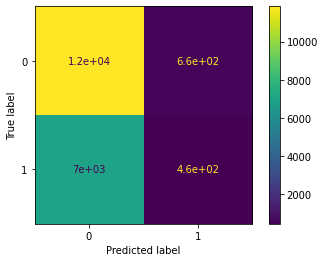

In [ ]:
metrics.plot_confusion_matrix(LR ,X_test, y_test)

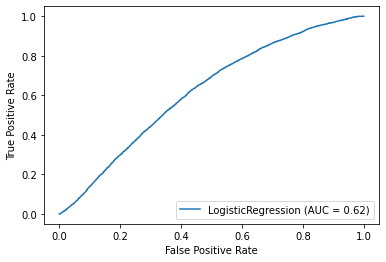

In [ ]:
metrics.plot_roc_curve(LR ,X_test, y_test)

We get very bad model having low accuracy score as well as other metrics score.


## Preprocessing for Text Data

Preprocessing steps:
1. Removing special characters
2. Convert sentence into lower case
3. Remove Stop Words
4. Stemming or Lemmatization

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [8]:
#initialize the Lemmatizer
lemmatizer = WordNetLemmatizer()

In [9]:
stop_words=set(stopwords.words("english"))

In [10]:
# text cleaning
def clean_text(text):
  text=re.sub(r"[^\w\s]",'',text,re.UNICODE)
  text=text.lower()
  text=[lemmatizer.lemmatize(token) for token in text.split(" ")]
  text=[lemmatizer.lemmatize(token,"v") for token in text]
  text=[word for word in text if not word in stop_words]
  text=" ".join(text)
  return text

In [11]:
clean_text_1 = df['question1'].apply(lambda x:clean_text(str(x)))
clean_text_2 = df['question2'].apply(lambda x:clean_text(str(x)))

In [12]:
df['clean_text_1'] = clean_text_1
df['clean_text_2'] = clean_text_2

In [13]:
df.head()

,Unnamed: 0,index,id,qid1,qid2,question1,question2,is_duplicate,len_question1,len_question2,no_of_words_1,no_of_words_2,clean_text_1,clean_text_2
0,0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,34,34,8,8,play pokémon go korea,play pokémon go china
1,1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,53,51,11,9,best side dish crab cake,good side dish buffalo chicken
2,2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,96,45,16,8,advisable better material crash test automobil...,best server setup buddypress
3,3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,44,52,7,9,improve logical program skill,improve logical skill program
4,4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,38,29,9,7,close see 3rd world war,close world war iii


## Text to Vector Representation

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer =  CountVectorizer(ngram_range=(2,2))
tfidf = TfidfVectorizer()

In [15]:
# calculating Jaccard distance

def get_jaccard_distance(sentence1, sentence2):
    """method to calculate the jaccard distance between two strings and return the same"""
    sentence1_lwr = str(sentence1).lower()
    sentence2_lwr = str(sentence2).lower()
    
    sentence1_tokens = set(nltk.word_tokenize(sentence1_lwr))
    sentence2_tokens = set(nltk.word_tokenize(sentence2_lwr))
    return nltk.jaccard_distance(sentence1_tokens, sentence2_tokens)

In [16]:
nltk.download('punkt')
df['jaccard_distance'] = df.apply(lambda x: get_jaccard_distance(x['question1'], x['question2']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df.head()

,Unnamed: 0,index,id,qid1,qid2,question1,question2,is_duplicate,len_question1,len_question2,no_of_words_1,no_of_words_2,clean_text_1,clean_text_2,jaccard_distance
0,0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,34,34,8,8,play pokémon go korea,play pokémon go china,0.200000
1,1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,53,51,11,9,best side dish crab cake,good side dish buffalo chicken,0.533333
2,2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,96,45,16,8,advisable better material crash test automobil...,best server setup buddypress,0.875000
3,3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,44,52,7,9,improve logical program skill,improve logical skill program,0.363636
4,4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,38,29,9,7,close see 3rd world war,close world war iii,0.615385


## Exploratory Data Analysis

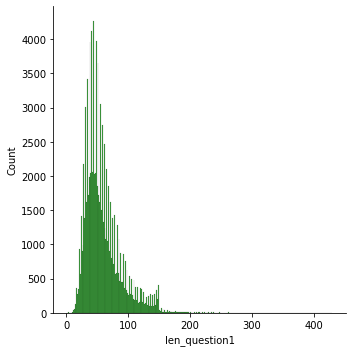

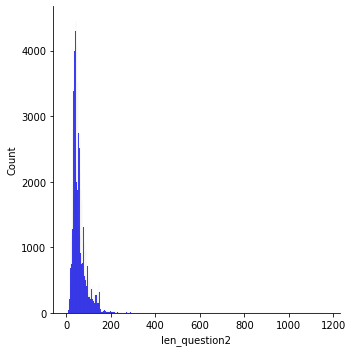

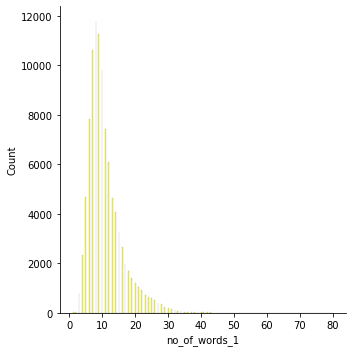

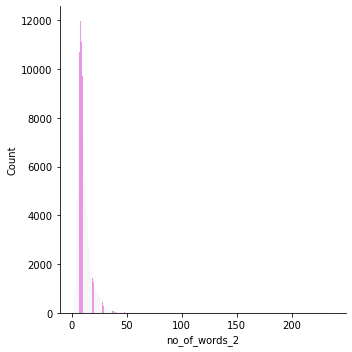

In [ ]:
sns.displot(x = df['len_question1'], color='green' )

sns.displot(x = df['len_question2'], color='blue')

sns.displot(x = df['no_of_words_1'], color = 'yellow')

sns.displot(x = df['no_of_words_2'], color='violet')

plt.show()

In [ ]:
df.groupby(by = 'is_duplicate')['len_question1','len_question2', 'no_of_words_1', 'no_of_words_2'].mean()


,len_question1,len_question2,no_of_words_1,no_of_words_2
is_duplicate,,,,
0,63.620096,64.321061,11.602777,11.953498
1,52.633577,52.851216,9.815872,9.858247


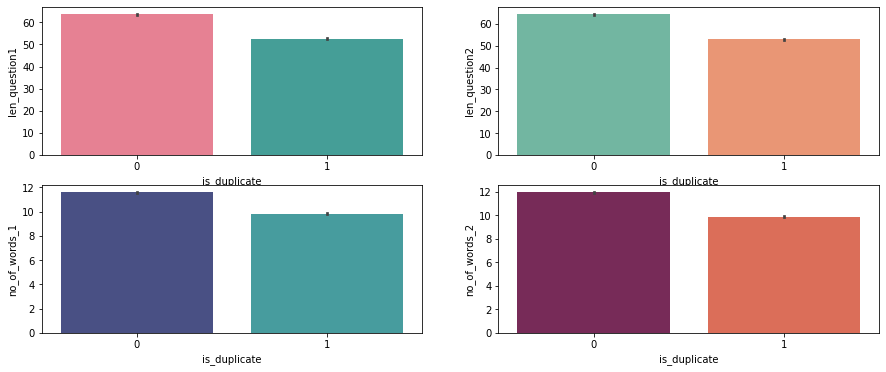

In [ ]:
fig, axs = plt.subplots(figsize=(15, 6),nrows=2,ncols=2)
sns.barplot(x= df['is_duplicate'], y=df['len_question1'], ax=axs[0][0], palette = 'husl')
sns.barplot(x= df['is_duplicate'], y=df['len_question2'], ax=axs[0][1], palette = 'Set2')
sns.barplot(x= df['is_duplicate'], y=df['no_of_words_1'], ax=axs[1][0], palette = 'mako')
sns.barplot(x= df['is_duplicate'], y=df['no_of_words_2'], ax=axs[1][1], palette = 'rocket')


Question pairs which are similar in nature having higher feature values than dissimilar pairs

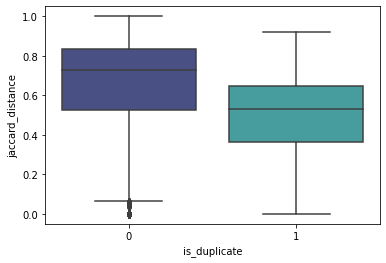

In [ ]:
sns.boxplot(y = df['jaccard_distance'], x = df['is_duplicate'], palette ='mako')

Question pairs which are similar in nature having higher Jaccard Distance than dissimilar pairs

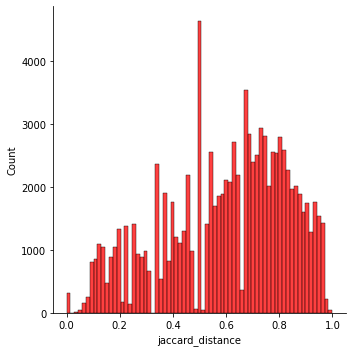

In [ ]:
sns.displot(x = df['jaccard_distance'], color='red')

## Model Building and Evaluation

In [17]:
questions = [x+' '+y for x,y in zip(df['clean_text_1'], df['clean_text_2'])]
vector_questions = vectorizer.fit_transform(questions)

In [18]:
vector_questions.shape

(100000, 471373)

In [19]:
data = vector_questions
target = df['is_duplicate']

In [20]:
# splitting into test and train

from sklearn.model_selection  import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)

## Logistic Regression

In [34]:
# Training the Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
tuned_hyperparameters = [{'C': [0.01, 0.1, 1, 10, 100]} ]

LR = GridSearchCV(LogisticRegression(), tuned_hyperparameters)
LR.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [35]:
print(LR.best_params_)
print(LR.best_estimator_)
print(LR.score(X_test, y_test))

{'C': 1}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.7687


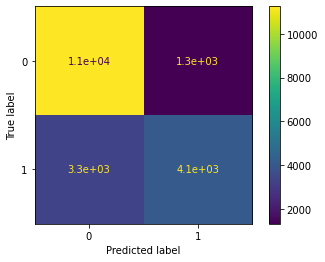

In [36]:
# Confusion Matrix
from sklearn import metrics
metrics.plot_confusion_matrix(LR, X_test, y_test)

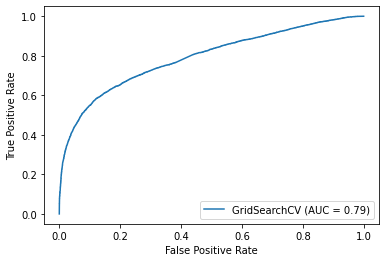

In [ ]:
# ROC AUC Curve
metrics.plot_roc_curve(LR, X_test,y_test)

In [ ]:
# Precision, Recall and F1-score
y_pred = LR.predict(X_test)
target_names = ['class_0','class_1']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class_0       0.77      0.90      0.83     12570
     class_1       0.76      0.55      0.64      7430

    accuracy                           0.77     20000
   macro avg       0.77      0.72      0.73     20000
weighted avg       0.77      0.77      0.76     20000



## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tuned_parameters = [{ 'criterion' :['gini', 'entropy'], 'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}]
DTC = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv = 5)
DTC.fit(X_test, y_test)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'criterion': ['gini', 'entropy'],
                  

In [ ]:
print('Best Parameters for Decision Tree Classifier :\n')
print(DTC.best_params_)
print(DTC.best_estimator_)
print(DTC.score(X_test, y_test))

Best Parameters for Decision Tree Classifier :

{'criterion': 'gini', 'max_depth': 150}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=150, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.75635


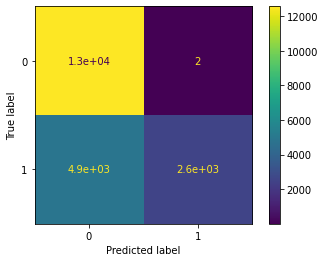

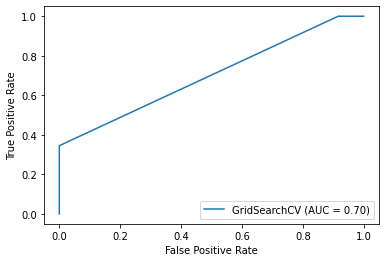

In [ ]:
# Confusion Matrix and ROC-AUC curve
metrics.plot_confusion_matrix(DTC, X_test, y_test)
metrics.plot_roc_curve(DTC, X_test,y_test)

In [ ]:
# Precision, Recall and F1-score
y_pred = DTC.predict(X_test)
target_names = ['class_0','class_1']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class_0       0.72      1.00      0.84     12570
     class_1       1.00      0.34      0.51      7430

    accuracy                           0.76     20000
   macro avg       0.86      0.67      0.67     20000
weighted avg       0.82      0.76      0.72     20000



## KNN Classifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'n_neighbors':[5,7,9,13,17], 'p':[1,2,3,4]}]

KNeighbors = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring='accuracy')
KNeighbors.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [5, 7, 9, 13, 17], 'p': [1, 2, 3, 4]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [28]:
print('Best Parameters for KNN Classifier :\n')
print(KNeighbors.best_params_)
print(KNeighbors.best_estimator_)
print(KNeighbors.score(X_test, y_test))

Best Parameters for KNN Classifier :

{'n_neighbors': 13, 'p': 2}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')
0.7219


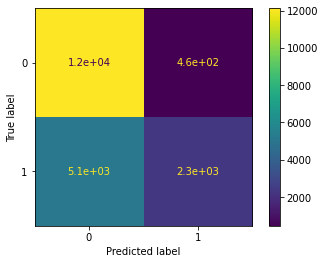

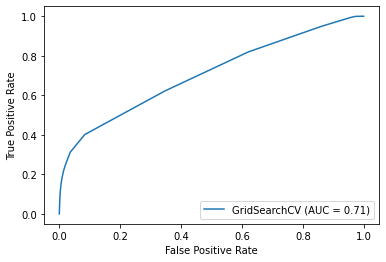

In [32]:
# Confusion Matrix and ROC-AUC Curve
metrics.plot_confusion_matrix(KNeighbors, X_test, y_test)
metrics.plot_roc_curve(KNeighbors, X_test, y_test)

In [33]:
# Precision, Recall and F1-score
y_pred = KNN.predict(X_test)
target_names = ['class_0','class_1']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class_0       0.74      0.77      0.75     12570
     class_1       0.57      0.54      0.55      7430

    accuracy                           0.68     20000
   macro avg       0.66      0.65      0.65     20000
weighted avg       0.68      0.68      0.68     20000



Here, Logistic regression performs better than other Models with accuracy of 77% and F1-score of 0.83

## Saving the Model and Vectorizer in Pickle